In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_excel("covid_World_updated.xlsx")
df.date=pd.to_datetime(df.date,infer_datetime_format=True)
#United States,Brazil,World,India
location_name="United States"
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


### Creating Data Frame with Total Cases lags

In [5]:
from fbprophet import Prophet

In [6]:
def accuracy(realSales_series, prediction_series):

    assert isinstance(realSales_series, pd.Series), 'Real Sales should be in pandas Series format'
    assert isinstance(prediction_series, pd.Series), 'Prediction should be in pandas Series format'
#     prediction_series=np.max(0,prediction_series)
    acc =round((1 - abs(prediction_series - realSales_series)/prediction_series) * 100,2)
    acc.loc[(realSales_series == 0) & (prediction_series != 0)] = 0
    acc.loc[(realSales_series == 0) & (prediction_series == 0)] = np.nan
    #acc.loc[acc > 95] = 100
    acc.loc[acc < 0] = 0
    acc.dropna()
    return acc

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [8]:
def forecasting(df_out,regressor,table,graph):
    
    df_out1=pd.DataFrame(columns=["ds","y"]) 
    
        
    df_out1['y']=df_out['Deaths']
    df_out1['ds']=df_out.index
    
    if regressor=="Confirmed":
        df_out1['ConLag5']=df_out['ConLag5']
#     elif regressor=="Cured":
#         df_out1['CurLag5']=df_out['CurLag5']
#     else:
#         df_out1['ConLag5']=df_out['ConLag5']
#         df_out1['CurLag5']=df_out['CurLag5']
        
        
    df_out1.reset_index(inplace=True,drop=True)
    
    #print(df_out1)
    
        
    model=Prophet(daily_seasonality=True,yearly_seasonality=False)
    
    if regressor=="Confirmed":
        model.add_regressor('ConLag5')
#     elif regressor=="Cured":
#         model.add_regressor('CurLag5')
#     else:
#         model.add_regressor('ConLag5')
#         model.add_regressor('CurLag5')
        
    #print(df_out)    
    model.fit(df_out1)
    
    future = model.make_future_dataframe(periods=5)
    
    if regressor=="Confirmed":
        conlag=list(df_out1['ConLag5'])
        for i in range(5,0,-1):
            conlag.append(list(df_location['total_cases'])[-i])
        #print(conlag)
            
        future['ConLag5']=list(conlag)
        #print(future)
#     elif regressor=="Cured":
#         curlag=list(df_out1['CurLag5'])
#         #curlag.append(list(df_State['Cured'])[-1])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])

#         future['CurLag5']=list(curlag)
#     else:
#         conlag=list(df_out1['ConLag5'])
#         for i in range(5,0,-1):
#             conlag.append(list(df_State['Confirmed'])[-i])
#         #conlag.append(list(df_State['Confirmed'])[-1])
#         curlag=list(df_out1['CurLag5'])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])
#         #curlag.append(list(df_State['Cured'])[-1])
#         future['ConLag5']=list(conlag)
#         future['CurLag5']=list(curlag)
#     #print(future)
    
    forecast=model.predict(future)
    if table=="Yes":
        print("Forecasted Table for number of Deaths for location: "+location_name+"\n")
        Forecast=pd.DataFrame()
        Forecast['Day']=forecast['ds']
        Forecast['Forecasted_Death']=[int(x) for x in list(forecast['yhat'])]
        Forecast['Lower Limit']=[int(x) for x in list(forecast['yhat_lower'])]
        Forecast['Upper Limit']=[int(x) for x in list(forecast['yhat_upper'])]
        Forecast.set_index('Day',inplace=True)
        print(Forecast.tail(5))
        
    return list(Forecast['Forecasted_Death'])[-1]

In [9]:
i=121
j=i-5
table="Yes"
graph="Yes"
regressor="Confirmed"
pred5=[]
while j>=0:
    df.index = pd.DatetimeIndex(df.date)
    df_location=df[df['location']==location_name]
    df_location=df_location[:-i]
    df_location['date']=df_location.index
    df_location.reset_index(inplace = True, drop = True)
    df_out={'Date': df_location.date.to_list(),
             'Deaths':df_location.total_deaths.to_list(),
            'ConLag5':df_location.total_cases.shift(5).to_list(),
           }
    df_out=pd.DataFrame(df_out)
    df_out.columns
    df_out=df_out.dropna()
    df_out.set_index('Date',inplace=True)
    for cols in df_out.columns:
        if cols=="Date":
            continue
        else:
            df_out[cols]=df_out[cols].astype(int)
            
    print('df_out')
    print(df_out)
            
    pred5.append(forecasting(df_out,regressor,table,graph))
    i=i-1
    j=j-1

df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-05-27   98916  1577287
2020-05-28  100442  1601434
2020-05-29  101617  1622670
2020-05-30  102836  1643238
2020-05-31  103781  1662302

[148 rows x 2 columns]


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-01            105609       104988       106220
2020-06-02            106378       105801       106948
2020-06-03            107536       106931       108150
2020-06-04            109153       108552       109783
2020-06-05            110416       109816       111108
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-05-28  100442  1601434
2020-05-29  101617  1622670
2020-05-30  102836  1643238
2020-05-31  103781  1662302
2020-06-01  104383  1681212

[149 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-11            114712       114071       115326
2020-06-12            115772       115168       116398
2020-06-13            117030       116409       117650
2020-06-14            117874       117232       118554
2020-06-15            118518       117850       119185
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-06-07  109802  1811277
2020-06-08  110514  1831821
2020-06-09  111007  1851520
2020-06-10  112006  1872660
2020-06-11  112924  1897838

[159 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-21            121926       121317       122556
2020-06-22            122791       122146       123423
2020-06-23            123807       123151       124426
2020-06-24            125142       124435       125754
2020-06-25            126715       125989       127343
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-06-17  116963  2023347
2020-06-18  117717  2048986
2020-06-19  118434  2074526
2020-06-20  119112  2094069
2020-06-21  119719  2114026

[169 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-01            129125       128540       129726
2020-07-02            130596       129980       131242
2020-07-03            131951       131293       132609
2020-07-04            133154       132433       133824
2020-07-05            134274       133506       135021
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-06-27  125039  2280912
2020-06-28  125539  2312302
2020-06-29  125804  2347022
2020-06-30  126140  2381361
2020-07-01  127410  2422310

[179 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-11            134007       133587       134439
2020-07-12            134560       134110       135053
2020-07-13            134944       134415       135459
2020-07-14            135364       134815       135906
2020-07-15            136144       135463       136754
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-07-07  130306  2686480
2020-07-08  131480  2739879
2020-07-09  132309  2794321
2020-07-10  133291  2839542
2020-07-11  134097  2888635

[189 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-21            140839       140408       141228
2020-07-22            141706       141218       142139
2020-07-23            142630       142180       143120
2020-07-24            143500       143021       144005
2020-07-25            144256       143670       144853
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-07-17  138358  3247684
2020-07-18  139266  3304942
2020-07-19  140119  3363056
2020-07-20  140534  3431574
2020-07-21  140906  3499291

[199 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-31            150387       149946       150836
2020-08-01            151236       150758       151676
2020-08-02            151972       151506       152480
2020-08-03            152558       152000       153095
2020-08-04            153218       152611       153838
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-07-27  146935  3902058
2020-07-28  148011  3970906
2020-07-29  149256  4034102
2020-07-30  150713  4112529
2020-07-31  152070  4178027

[209 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-10            160856       160283       161447
2020-08-11            161399       160800       162022
2020-08-12            162384       161744       163014
2020-08-13            163412       162757       164126
2020-08-14            164405       163641       165153
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-08-06  158256  4562037
2020-08-07  160104  4620444
2020-08-08  161356  4667955
2020-08-09  162425  4713562
2020-08-10  162938  4771087

[219 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-20            170612       169785       171401
2020-08-21            171475       170564       172327
2020-08-22            172215       171324       173080
2020-08-23            172687       171863       173656
2020-08-24            173070       172109       174133
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-08-16  169481  5094394
2020-08-17  170052  5141207
2020-08-18  170497  5197148
2020-08-19  171821  5248242
2020-08-20  173177  5313080

[229 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-30            183259       182654       183824
2020-08-31            183954       183394       184533
2020-09-01            184711       184103       185336
2020-09-02            185867       185199       186535
2020-09-03            187127       186427       187843
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-08-26  178486  5573847
2020-08-27  179714  5623727
2020-08-28  180824  5668105
2020-08-29  181773  5702611
2020-08-30  182779  5740909

[239 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-09            191026       190562       191510
2020-09-10            192206       191698       192695
2020-09-11            193279       192707       193776
2020-09-12            194196       193653       194744
2020-09-13            194926       194335       195570
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-09-05  187765  5997163
2020-09-06  188538  6031013
2020-09-07  188941  6075652
2020-09-08  189208  6114406
2020-09-09  189679  6150655

[249 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-19            198579       198190       198977
2020-09-20            199317       198907       199732
2020-09-21            199999       199548       200445
2020-09-22            200320       199832       200809
2020-09-23            201320       200792       201837
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-09-15  194530  6359720
2020-09-16  195937  6397227
2020-09-17  196802  6445288
2020-09-18  197633  6486108
2020-09-19  198589  6519979

[259 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

In [10]:
df_output=pd.DataFrame()
mape=[]
df_location=df[df['location']==location_name]
real=list(df_location.total_deaths[-len(pred5):])
for i in range(len(real)):
    mape.append(mean_absolute_percentage_error(real[i],pred5[i]))
score=accuracy(pd.Series(real),pd.Series(pred5))
df_output['Date']=list(df[df['location']==location_name].date[-len(pred5):])
df_output['Real']=real
df_output['Pred']=pred5
df_output['Accuracy']=score
df_output['Error%(MAPE)']=mape
#df_output.set_index(df_output.Date,inplace=True,drop=True)

In [11]:
with pd.option_context('display.max_columns', 200,'display.max_rows', 200):
    display(df_output)

,Date,Real,Pred,Accuracy,Error%(MAPE)
0,2020-06-05,108211.0,110416,98.00,2.037686
1,2020-06-06,109143.0,111241,98.11,1.922249
2,2020-06-07,109802.0,112016,98.02,2.016357
3,2020-06-08,110514.0,112734,98.03,2.008795
4,2020-06-09,111007.0,113429,97.86,2.181844
5,2020-06-10,112006.0,114300,97.99,2.048105
6,2020-06-11,112924.0,115598,97.69,2.367964
7,2020-06-12,113820.0,116502,97.70,2.356352
8,2020-06-13,114669.0,117555,97.54,2.516809
9,2020-06-14,115436.0,118109,97.74,2.315569


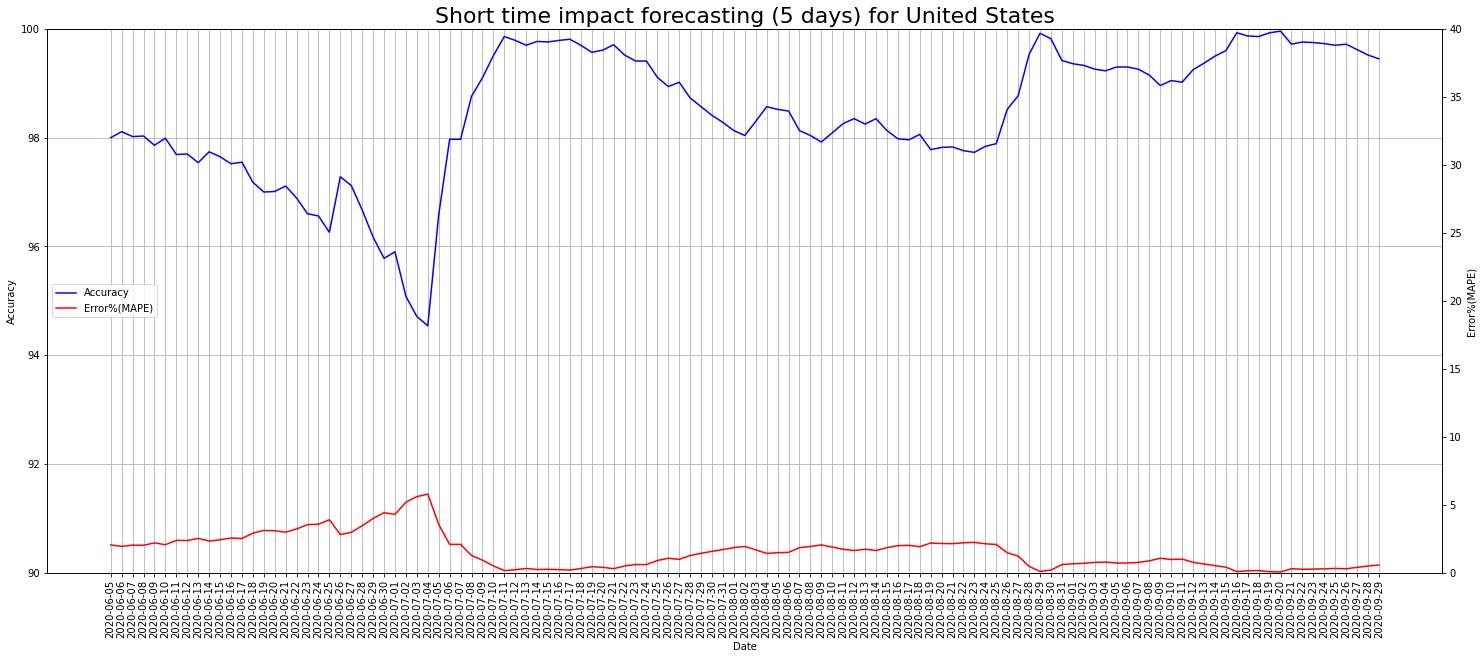

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = [25,10]
fig, ax1 = plt.subplots()
#df_output.set_index(df_output.Date,inplace=True,drop=True)
ax2 = ax1.twinx()
#r2=round(r2_score(real, pred14),2)*100
title="Short time impact forecasting (5 days) for "+location_name
plt.title(title,fontsize= 22)
ax1.grid()
#plt.xticks(df_output.Date,rotation=90)
ax1.set_ylim(90,100)
ax1.plot(df_output.Date,df_output['Accuracy'],color="blue",label='Accuracy')

ax2.plot(df_output.Date,df_output['Error%(MAPE)'],color="red",label='Error%(MAPE)')

ax2.set_ylim([0, 40])
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_xticks(df_output['Date'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=6)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Date')
ax2.set_ylabel('Error%(MAPE)')

plt.show()